In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Movie recommender based on the MovieLens dataset

[Dataset](https://grouplens.org/datasets/movielens/)

## 1. Load data and inspect

In [2]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [6]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
# drop unnecessary columns
movies = movies.drop(columns="genres")
ratings = ratings.drop(columns="timestamp")

## 2. Create feature set

Use the two dataframes and create something that looks like this:

| movieId | userA | userB | ... |
|---------|-------|-------|-----|
| 1 | 5 | 4 | ... |
| 2 | 4 | 5 | ... |
| 3 | 0 | 0 | ... |
| 4 | 1 | 2 | ... |

In [8]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [9]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [10]:
df = ratings.merge(movies, how="left", on="movieId")

In [11]:
df.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,1,3,4.0,Grumpier Old Men (1995)
2,1,6,4.0,Heat (1995)
3,1,47,5.0,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,"Usual Suspects, The (1995)"


Filter: Exclude movies that have less than n ratings

In [12]:
ratings_pm = ratings.groupby("movieId").agg({"rating": "count"}).rename(columns={"rating": "no_of_ratings"})
ratings_pm.describe()

,no_of_ratings
count,9724.000000
mean,10.369807
std,22.401005
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,329.000000


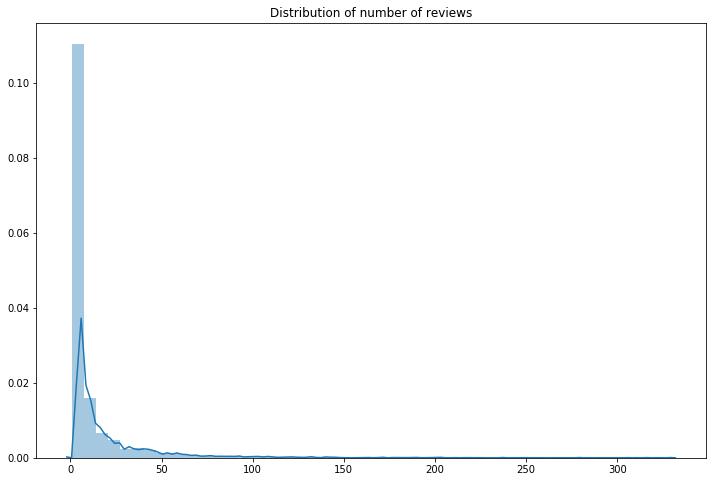

In [13]:
fig = plt.figure(figsize=(12,8))
sns.distplot(ratings_pm);
plt.title("Distribution of number of reviews");

Based on our thorough analysis, we set the threshold to 9!

In [14]:
df = df.merge(ratings_pm, how="inner", on="movieId")

In [15]:
df_movies = df[df["no_of_ratings"].ge(9)]

In [16]:
df_movies["movieId"].nunique()

2441

In [17]:
df_movies.head()

,userId,movieId,rating,title,no_of_ratings
0,1,1,4.0,Toy Story (1995),215
1,5,1,4.0,Toy Story (1995),215
2,7,1,4.5,Toy Story (1995),215
3,15,1,2.5,Toy Story (1995),215
4,17,1,4.5,Toy Story (1995),215


In [18]:
movie_features = df_movies.pivot_table(index="movieId",
                                       columns="userId",
                                       values="rating").fillna(0)

In [19]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


In [20]:
from scipy.sparse import csr_matrix

In [21]:
mat_movie_features = csr_matrix(movie_features)

In [22]:
mat_movie_features

<2441x610 sparse matrix of type '<class 'numpy.float64'>'
	with 82664 stored elements in Compressed Sparse Row format>

## 3. Modelling

Train KNN

In [23]:
from sklearn.neighbors import NearestNeighbors

In [24]:
model_knn = NearestNeighbors(metric="cosine",
                             algorithm="brute",
                             n_jobs=-1)
model_knn.fit(mat_movie_features)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=5, p=2, radius=1.0)

After fitting the KNN, we can ask for the k nearest neighbors of a given vector, by passing a vector of a movie

In [25]:
movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0


for a given vector, knn returns the 6 nearest vectors, including the one passed, as a tuple of two arrays.

The first array is the distance measure, the second the positional index of the vectors.

In [26]:
movie_features.loc[2].head()

userId
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: 2, dtype: float64

In [27]:
# have to convert series to 2d-array for the kneighbors method
type(movie_features.loc[2].values.reshape(1,-1))

numpy.ndarray

In [28]:
model_knn.kneighbors(movie_features.loc[2].values.reshape(1,-1), n_neighbors=6)

(array([[0.        , 0.41156227, 0.45018189, 0.45501892, 0.46195443,
         0.47512358]]), array([[  1, 189, 248, 191, 238, 282]]))

# 4. Build a move recommender

In order for us to match indeces with movieIds, we need a way to translate them

-> Create a list of movies with movieId as index and title as values

In [29]:
movie_list = df_movies[["movieId", "title"]].drop_duplicates().set_index("movieId").sort_index()

In [30]:
movie_list.head()

,title
movieId,
1,Toy Story (1995)
2,Jumanji (1995)
3,Grumpier Old Men (1995)
5,Father of the Bride Part II (1995)
6,Heat (1995)


In [31]:
movie_id = 2
movie_list.loc[movie_id]

title    Jumanji (1995)
Name: 2, dtype: object

In [32]:
# For a given title, return vector

distance, indices = model_knn.kneighbors(movie_features.loc[movie_id].values.reshape(1,-1), n_neighbors=6)

In [33]:
def get_recommendations_from_movieId(movie_id):
    return model_knn.kneighbors(movie_features.loc[movie_id].values.reshape(1,-1), n_neighbors=6)

In [34]:
distance

array([[0.        , 0.41156227, 0.45018189, 0.45501892, 0.46195443,
        0.47512358]])

In [35]:
indices

array([[  1, 189, 248, 191, 238, 282]])

translate back to title

In [36]:
movie_list.iloc[1]

title    Jumanji (1995)
Name: 2, dtype: object

In [37]:
movie_list.iloc[189]

title    Lion King, The (1994)
Name: 364, dtype: object

In [38]:
def get_title_from_pi(i):
    return movie_list.iloc[i]["title"]

In [39]:
get_title_from_pi(189)

'Lion King, The (1994)'

Iterate over results and print all recommendations

In [40]:
# first, flatten the 2d array, to 1d
indices.flatten()

array([  1, 189, 248, 191, 238, 282])

In [41]:
distance.flatten()

array([0.        , 0.41156227, 0.45018189, 0.45501892, 0.46195443,
       0.47512358])

In [42]:
# combine both arrays so we can iterate through pairs of index + distance
list(zip(indices.flatten(), distance.flatten()))

[(1, 0.0),
 (189, 0.4115622741415874),
 (248, 0.4501818938444998),
 (191, 0.45501892320213067),
 (238, 0.46195443302270334),
 (282, 0.475123579391069)]

In [43]:
# that gives us control over the positional index and the distance for each iteration
for i, d in zip(indices.flatten(), distance.flatten()):
    print(i)
    print(d)

1
0.0
189
0.4115622741415874
248
0.4501818938444998
191
0.45501892320213067
238
0.46195443302270334
282
0.475123579391069


In [44]:
# but we want to control for the first iteration, which is the movie we passed
recommendations = list(zip(indices.flatten(), distance.flatten()))
for i in range(6):
    idx, d = recommendations[i]
    
    # the first iteration is the movie we passed
    if i == 0:
        print(f"Recommendations for {get_title_from_pi(idx)}")
        print("--------------------------\n")
    else:
        print(f"{i}: {get_title_from_pi(idx)}, with distance {round(d,2)}")

Recommendations for Jumanji (1995)
--------------------------

1: Lion King, The (1994), with distance 0.41
2: Mrs. Doubtfire (1993), with distance 0.45
3: Mask, The (1994), with distance 0.46
4: Jurassic Park (1993), with distance 0.46
5: Home Alone (1990), with distance 0.48


In [45]:
def get_recommendations(indices, distances):
    recommendations = list(zip(indices.flatten(), distances.flatten()))
    for i in range(6):
        idx, d = recommendations[i]

        # the first iteration is the movie we passed
        if i == 0:
            print(f"Recommendations for {get_title_from_pi(idx)}")
            print("--------------------------\n")
        else:
            print(f"{i}: {get_title_from_pi(idx)}, with distance {round(d,2)}")

In [47]:
title = "Grumpier Old Men (1995)"

In [48]:
(movie_list
 .reset_index()
 .set_index("title")).loc[title]["movieId"]

3

In [49]:
get_recommendations_from_movieId(3)

(array([[4.44089210e-16, 5.52013240e-01, 5.53215549e-01, 5.54917572e-01,
         5.63753375e-01, 5.82197994e-01]]),
 array([[   2, 1251,  333,  341,  324,    3]]))

In [50]:
indices

array([[  1, 189, 248, 191, 238, 282]])

In [52]:
distances, indices = get_recommendations_from_movieId(3)
get_recommendations(indices, distances)

Recommendations for Grumpier Old Men (1995)
--------------------------

1: Grumpy Old Men (1993), with distance 0.55
2: Striptease (1996), with distance 0.55
3: Nutty Professor, The (1996), with distance 0.55
4: Twister (1996), with distance 0.56
5: Father of the Bride Part II (1995), with distance 0.58


So far, we can now retrieve recommendations based on string input, if the string input exactly matches a movie in our database.

We want to introduce some tolerance. We need to build a search engine

--> Fuzzy String Matching

In [53]:
from fuzzywuzzy import fuzz

In [54]:
fuzz.ratio("Hello", "hello")

80

In [55]:
fuzz.ratio("Hello", "Hello")

100

In [56]:
fuzz.ratio("Hello".lower(), "hello".lower())

100

-----

In [64]:
# create a dictionary with name as key and movieId as value
movie_index = {movie: i for i, movie in movie_list.to_dict()["title"].items()}

In [68]:
favorite_movie = "grumpy old man"

In [58]:
import re

In [65]:
re.findall(r"(.*) \(\d{4}\)$", "Grumpy Old Men (1993)")[0]

'Grumpy Old Men'

In [69]:
matched = []
for title, index in movie_index.items():
    # remove year from title
    ex_title = re.findall(r"(.*) \(\d{4}\)$", title)[0]
    
    # compute ratio and remove case-sensitivity
    ratio = fuzz.ratio(ex_title.lower(), favorite_movie.lower())
    
    if ratio >= 60:
        matched.append((title, index, ratio))    

In [70]:
matched

[('Grumpier Old Men (1995)', 3, 80),
 ('Repo Man (1984)', 1965, 64),
 ('Grumpy Old Men (1993)', 3450, 93)]

In [78]:
# sort all matches based on ratio and get the movieId with the highest
sorted(matched, key=lambda x: x[2], reverse=True)[0][1]

3450

# Putting all pieces together

In [84]:
def find_movie_id(movie_title):
    matched = []
    for title, index in movie_index.items():
        # remove year from title
        ex_title = re.findall(r"(.*) \(\d{4}\)$", title)[0]

        # compute ratio and remove case-sensitivity
        ratio = fuzz.ratio(ex_title.lower(), movie_title.lower())

        if ratio >= 60:
            matched.append((title, index, ratio))
    
    return sorted(matched, key=lambda x: x[2], reverse=True)[0][1]

In [86]:
find_movie_id("le haine")

2606

In [89]:
movie_list.loc[find_movie_id("lion king")]

title    Lion King, The (1994)
Name: 364, dtype: object

In [91]:
def recommend_movies(title):
    distances, indices = get_recommendations_from_movieId(find_movie_id(title))
    get_recommendations(indices, distances)

In [92]:
recommend_movies("La Haine")

Recommendations for Flashdance (1983)
--------------------------

1: Fame (1980), with distance 0.39
2: Some Kind of Wonderful (1987), with distance 0.56
3: Pretty in Pink (1986), with distance 0.58
4: Elephant (2003), with distance 0.58
5: Passion of the Christ, The (2004), with distance 0.59


In [93]:
recommend_movies("Hate")

Recommendations for Heat (1995)
--------------------------

1: Rock, The (1996), with distance 0.48
2: Twelve Monkeys (a.k.a. 12 Monkeys) (1995), with distance 0.49
3: Léon: The Professional (a.k.a. The Professional) (Léon) (1994), with distance 0.5
4: Casino (1995), with distance 0.51
5: Fargo (1996), with distance 0.51


In [94]:
recommend_movies("Matrix")

Recommendations for Matrix, The (1999)
--------------------------

1: Fight Club (1999), with distance 0.29
2: Star Wars: Episode V - The Empire Strikes Back (1980), with distance 0.3
3: Saving Private Ryan (1998), with distance 0.32
4: Star Wars: Episode IV - A New Hope (1977), with distance 0.34
5: Star Wars: Episode VI - Return of the Jedi (1983), with distance 0.34


In [95]:
recommend_movies("Birdman")

Recommendations for Iron Man (2008)
--------------------------

1: Dark Knight, The (2008), with distance 0.33
2: WALL·E (2008), with distance 0.33
3: Avengers, The (2012), with distance 0.34
4: Iron Man 2 (2010), with distance 0.36
5: Avatar (2009), with distance 0.38


In [96]:
recommend_movies("Chappy")

Recommendations for Chappie (2015)
--------------------------

1: Dictator, The (2012), with distance 0.37
2: Her (2013), with distance 0.43
3: Pacific Rim (2013), with distance 0.43
4: Fast & Furious (Fast and the Furious 4, The) (2009), with distance 0.45
5: The Interview (2014), with distance 0.46


In [97]:
recommend_movies("2 fast 2 furious")

Recommendations for Fast and the Furious, The (2001)
--------------------------

1: Gone in 60 Seconds (2000), with distance 0.45
2: Lara Croft: Tomb Raider (2001), with distance 0.46
3: Training Day (2001), with distance 0.46
4: Final Fantasy: The Spirits Within (2001), with distance 0.48
5: 2 Fast 2 Furious (Fast and the Furious 2, The) (2003), with distance 0.48


In [98]:
recommend_movies("Da vinci code")

Recommendations for Da Vinci Code, The (2006)
--------------------------

1: 300 (2007), with distance 0.4
2: Wedding Crashers (2005), with distance 0.43
3: War of the Worlds (2005), with distance 0.43
4: Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005), with distance 0.44
5: National Treasure (2004), with distance 0.44


In [99]:
recommend_movies("joker")

Recommendations for Clockers (1995)
--------------------------

1: Nobody's Fool (1994), with distance 0.6
2: Stuart Saves His Family (1995), with distance 0.62
3: Serious Man, A (2009), with distance 0.64
4: Bad News Bears, The (1976), with distance 0.65
5: Where the Wild Things Are (2009), with distance 0.65


In [100]:
recommend_movies("trainspotting")

Recommendations for Trainspotting (1996)
--------------------------

1: Reservoir Dogs (1992), with distance 0.41
2: Fight Club (1999), with distance 0.44
3: Clockwork Orange, A (1971), with distance 0.45
4: Pulp Fiction (1994), with distance 0.46
5: Usual Suspects, The (1995), with distance 0.46
